# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


This project deals with classifying Traffic Signals using a Deep Learning Technique (Convolutional Neural Network).
The goals / steps of this project are the following:

- Load the data set (see below for links to the project data set).
- Explore, summarize and visualize the data set.
- Preprocessing the data.
- Design, train and test a model architecture.
- Use the model to make predictions on new images.
- Analyze the softmax probabilities of the new images.


In [27]:
#Import all the required libraries

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import math
import csv
import time
import glob
import pickle
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten

---
## Step 1: Load The Data

In [28]:
training_file = "C:/Users/harsh/Downloads/traffic-signs-data/train.p"
validation_file="C:/Users/harsh/Downloads/traffic-signs-data/valid.p"
testing_file = "C:/Users/harsh/Downloads/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']
x_valid, y_valid=valid['features'],valid['labels']

---
## Step 2: Explore, Summarize and Visualize the Data

- The data is explored by studying the dimension of arrays of different types of samples. 
- Then respective histogram is plotted to study the frequency of each of the classes in three types of data.
- Grey Scaling has not been included because it does not increase the efficiency of the model.


In [29]:
# Number of training examples
n_train = x_train.shape[0]

# Number of validation examples
n_valid=x_valid.shape[0]

# Number of testing examples
n_test = x_test.shape[0]

# the Shape of an image
image_shape = x_train.shape[1:4]


img_size=x_train.shape[1] 

n_classes = 43 #chosen because 43 classes of German Traffic Signs
 
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


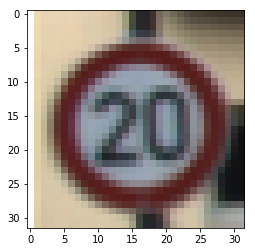

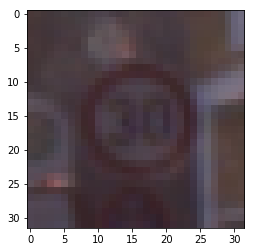

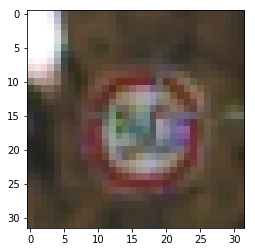

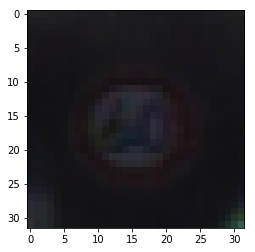

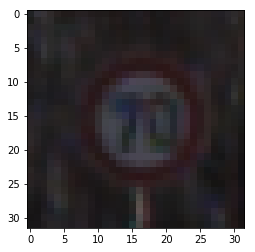

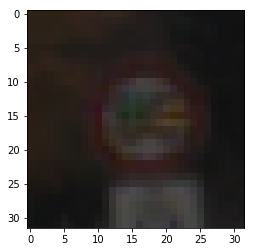

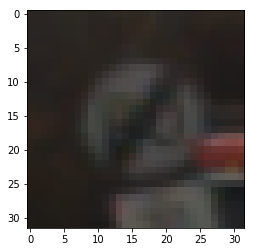

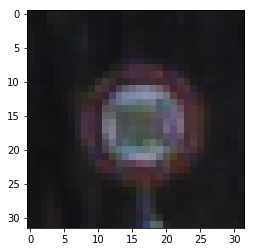

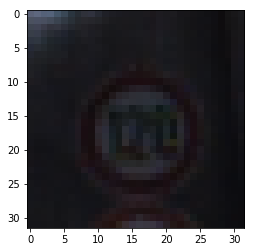

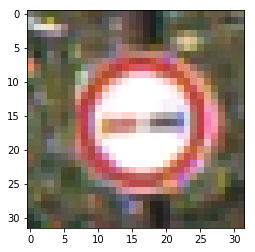

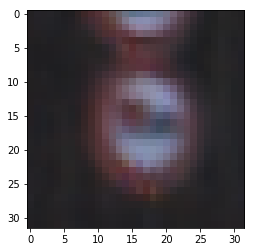

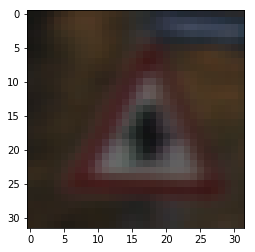

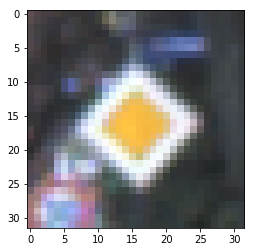

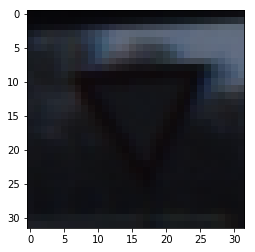

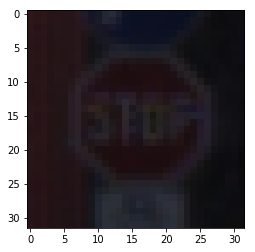

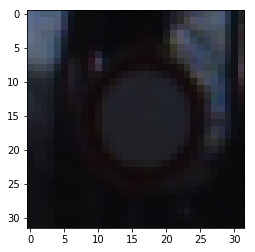

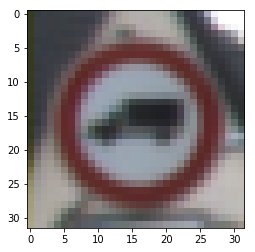

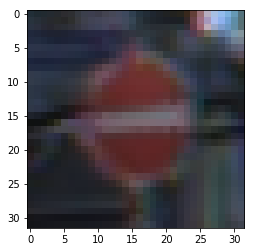

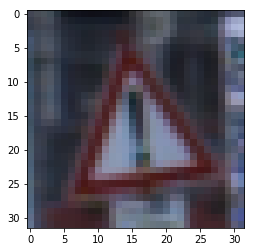

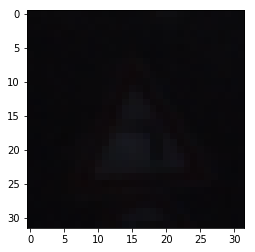

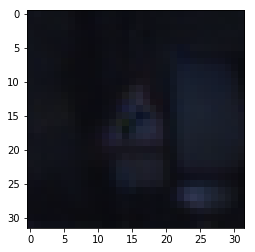

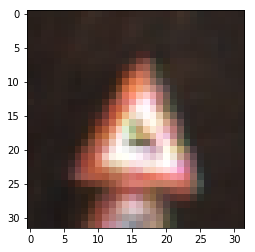

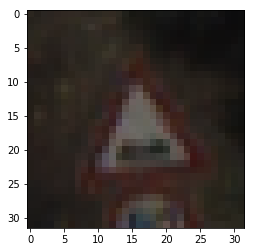

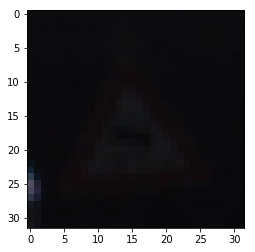

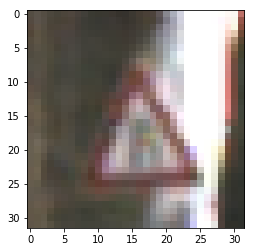

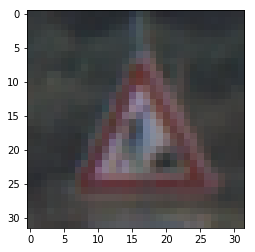

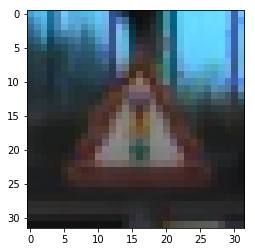

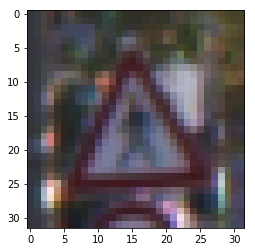

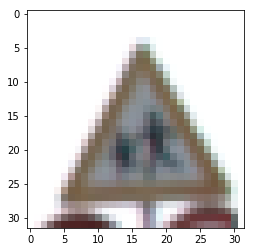

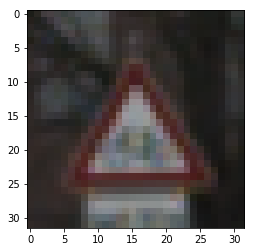

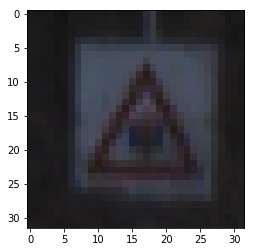

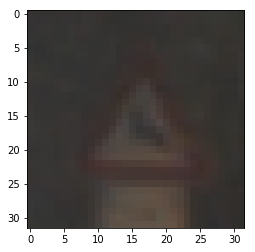

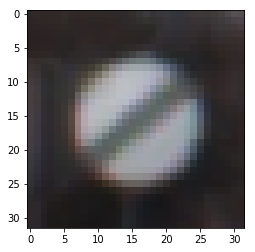

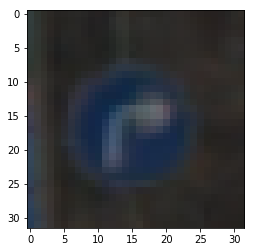

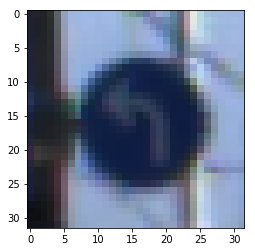

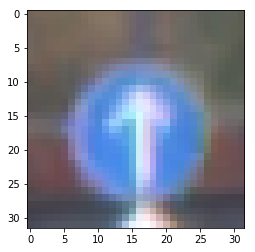

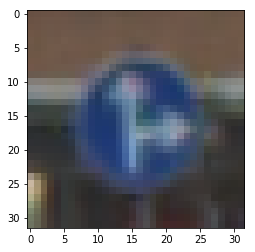

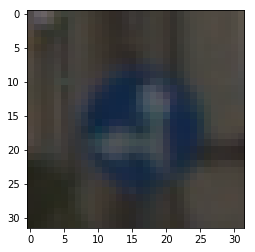

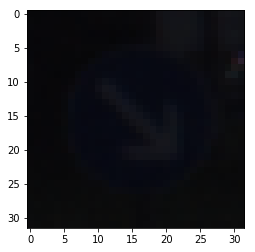

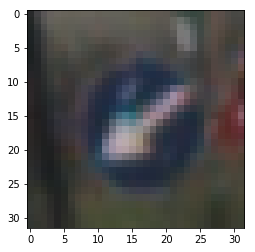

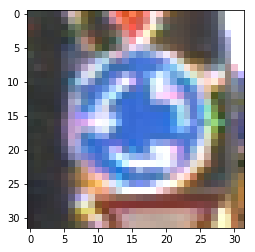

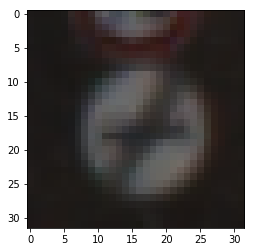

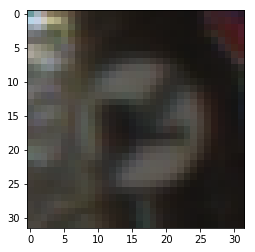

In [30]:
#display first images of each of the classes
for i in range(0,n_classes):
    X_Selected=x_train[y_train==i]
    plt.imshow(X_Selected[0, :, :, :])
    plt.show()

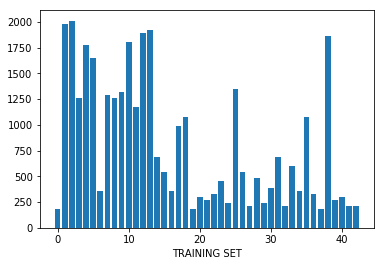

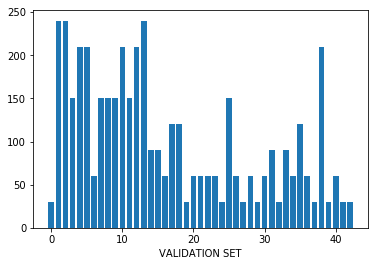

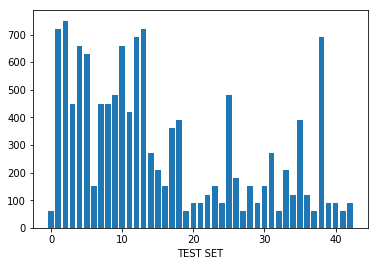

In [31]:
def plot_histogram(data, name):
  class_list = range(n_classes)
  label_list = data.tolist()
  counts = [label_list.count(i) for i in class_list]
  plt.bar(class_list, counts)
  plt.xlabel(name)
  plt.show()

plot_histogram(y_train, name = "TRAINING SET")
plot_histogram(y_valid, name = "VALIDATION SET")
plot_histogram(y_test, name = "TEST SET")

---
## Step 3: Preprocessing the Data

- This step involves normalizing the data and assigning the respective labels of y.
- The data is shuffled and then the some part of the training data is split into the validation set.
- The dimensions of the data is published at the end of this step.
- The gap of -0.5 to 0.5 is chosen because this ensures the intermediate numbers generated by matrix multiplication will not grow to be too large.
- One hot encoded the labels because Classifying traffic signs involves dealing with multiple classes where binary classification is extended for all the classes. 
- Grey Scaling has been excluded as it did not increase the accuracy of the model. 
- To increase the amount of training data, i transformed and augmented the image, but accuracy was not the best and it took more than 15 mins for 1 epoch.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
def normalize(data):
    return (data.astype('float32') / 255.) - 0.5 

def label_binarizer(labels):
    lbr = preprocessing.LabelBinarizer()
    lbr.fit(labels)
    return lbr

def preprocess(x_train, y_train, x_test, y_test):
    # Shuffle train data
    x_train, y_train = shuffle(x_train, y_train, random_state = 528)
    # Normalize
    x_train = normalize(x_train)
    x_test = normalize(x_test)
   
    # One hot encode labels
    lbr = label_binarizer(y_train)
    y_train = lbr.transform(y_train)
    y_test = lbr.transform(y_test)
    
    # Split training set to training and validation
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify = y_train ) 
    return x_train, x_val, x_test, y_train, y_val, y_test

print("Before pre processing shape of train and test dataset")
print(x_train_orig.shape, x_test_orig.shape)
x_train, x_val, x_test, y_train, y_val, y_test = preprocess(x_train, y_train, x_test, y_test)
print("After pre processing shape of train, validation and test dataset")
print(x_train.shape, x_val.shape, x_test.shape)

Before pre processing shape of train and test dataset
(34799, 32, 32, 3) (12630, 32, 32, 3)
After pre processing shape of train, validation and test dataset
(27839, 32, 32, 3) (6960, 32, 32, 3) (12630, 32, 32, 3)


---
## Step 4: Designing the Neural Network Architecture

This step is defining the architecture of Neural Network which has very similar values of that of Classroom's LeNet Neural Network Architecture.The hyperparameters are chosen accordingly by varying the learning rates, epochs and changing the Optimizer method.
The overview of the architecture is as follows:
- Used LeNet architecture.
- Conv layers having 6 and 16 filters of size 5x5 on 3 channels having strides of (1,1,1,1).
- max pool layer of strides (1,2,2,1)
- 3 Fully connected layers connecting 400x120x84x43 nodes
- InputLayer: Size (N, 32, 32, 3)
- N normalized images of size (32, 32, 3)
- ConvLayer1: Size (N, 28, 28, 6)
- Filter bias values of size (6) and weight values of size (5, 5, 3, 6) with strides (1,1) on height and width of image and VALID padding will produce N matrices of size (28, 28, 6).
- ReluLayer1: Size (N, 28, 28, 6)

- MaxPoolinglayer1: Size (N, 14, 14, 6)
- Applied max pooling of size (2,2) with strides (2,2) on height and width of an image proudces N matrices of size (14,14,6)

- ConvLayer2: Size (N, 10, 10, 16)
- Filter bias values of size (16) and weight values of size (5, 5, 6, 16) with strides (1,1) on height and width of image and VALID padding will produce N matrices of size (10, 10, 16).
- ReluLayer2: Size (N, 10, 10, 16)

- MaxPoolinglayer2: Size (N, 5, 5, 16)
- Applied max pooling of size (2,2) with strides (2,2) on height and width of an image proudces N matrices of size (5,5,16)
- FCLayer1: Size (400, 120)
- FCLayer2: Size (120, 84)
- FCLayer3: Size (84, 43)

This is the final layer that produces values for 43 class labels.

In [33]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1

    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = tf.contrib.layers.flatten(conv2)

    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b

    return logits

In [34]:
mu = 0.0
sigma = 0.1
base_rate = 0.0005 #Base learning rate
dropout = 0.5 #dropout rate
rate = base_rate
EPOCHS = 20
BATCH_SIZE = 128
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.float32, (None, n_classes))
keep_prob = tf.placeholder(tf.float32)
fc = LeNet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc,labels= y))
opt = tf.train.AdamOptimizer(learning_rate=0.001) 
train_op = opt.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [35]:
def next_batch(x_data, y_data, batch_size, step):
    batch_start = step*batch_size
    batch_x = x_data[batch_start:batch_start + batch_size]
    batch_y = y_data[batch_start:batch_start + batch_size]
    return batch_x, batch_y

#Function to calculate loss and accuracy
def eval_data(x_data, y_data):
    steps_per_epoch = len(x_data) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_accu, total_loss = 0, 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = next_batch(x_data, y_data, BATCH_SIZE, step)
        loss, accu = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_accu += (accu * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_accu/num_examples

In [36]:
EPOCHS = 20
BATCH_SIZE = 128

saver = tf.train.Saver()

init = tf.global_variables_initializer()


with tf.Session() as sess:
    
    sess.run(init)
    steps_per_epoch = len(x_train) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE

    # Train model
    for i in range(EPOCHS):
        for step in range(steps_per_epoch):
            batch_x, batch_y = next_batch(x_train, y_train, BATCH_SIZE, step)
            loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

        val_loss, val_acc = eval_data(x_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Validation loss = {:.3f}".format(val_loss))
        print("Validation accuracy = {:.3f}".format(val_acc))
        print()

       # Evaluate on the test data
   
    save_path=saver.save(sess, "./convolutional-net")
    print('Training Model saved at: %s'% save_path)
    test_loss, test_acc = eval_data(x_test, y_test)
    print("Test loss = {:.3f}".format(test_loss))
    print("Test accuracy = {:.3f}".format(test_acc))

EPOCH 1 ...
Validation loss = 0.920
Validation accuracy = 0.730

EPOCH 2 ...
Validation loss = 0.439
Validation accuracy = 0.882

EPOCH 3 ...
Validation loss = 0.287
Validation accuracy = 0.927

EPOCH 4 ...
Validation loss = 0.224
Validation accuracy = 0.944

EPOCH 5 ...
Validation loss = 0.184
Validation accuracy = 0.955

EPOCH 6 ...
Validation loss = 0.150
Validation accuracy = 0.963

EPOCH 7 ...
Validation loss = 0.131
Validation accuracy = 0.971

EPOCH 8 ...
Validation loss = 0.124
Validation accuracy = 0.973

EPOCH 9 ...
Validation loss = 0.115
Validation accuracy = 0.976

EPOCH 10 ...
Validation loss = 0.139
Validation accuracy = 0.970

EPOCH 11 ...
Validation loss = 0.114
Validation accuracy = 0.976

EPOCH 12 ...
Validation loss = 0.125
Validation accuracy = 0.974

EPOCH 13 ...
Validation loss = 0.106
Validation accuracy = 0.980

EPOCH 14 ...
Validation loss = 0.118
Validation accuracy = 0.977

EPOCH 15 ...
Validation loss = 0.117
Validation accuracy = 0.977

EPOCH 16 ...
Valida

---
## Hyperparameter Tuning

- Used AdamOptimizer with learning rate 0.001.Tried 0.0001 and 0.005.
- Batch size is 128. Tried with 64 and 128 but 128 looks to be the best for accuracy.
- Ran on 20 epochs. Tried with 5,10,15 and 20.
- Dropout 50% on fully connected layer.

---
## Steps followed for designing the Neural Network Architecture

- Normalized the dataset
- One hot encoded the labels
- Splitted training set into train and validation set
- Then tried augmented data but  and it does not improve the performance.
- Tried several epochs and batch size configuration but did not improve.
- Tried initially with inception module but took very long time to run the model. Choosing the parameters were very difficult. So shifted to traditional LeNet architecture. 
- Finally Implemented LeNet architecture for initial run and ran it for batch_size=128 and epochs=20. Results are validation accuracy = 98% and test accuracy = 90%.

Conclusion:


LeNet is already a proven architecture to classify images with a very small parameter values which fits well and thus does a pretty good job in combination with dropout for overfitting prevention.Overall the accuracy for all the validation, test and downloaded image dataset are pretty good with this simple yet effective architecture.


---
## Step 5: Testing on New Images

- I have collected around 9 images from Google Search.
- The images are converted to 32x32x3 height and width scale.
- The images include that of Road Work, Stop sign, No passing, Left Ahead, Yield and others. 
- The images are visualized as follows:

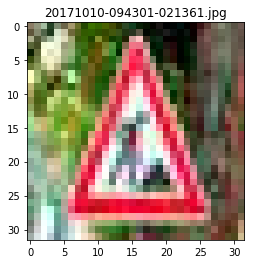

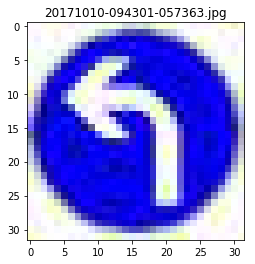

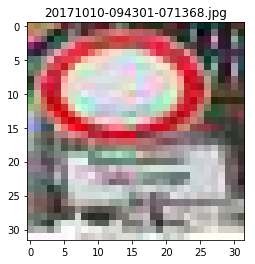

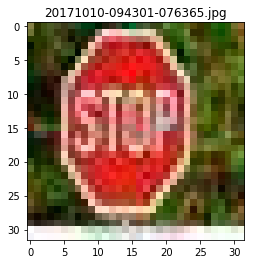

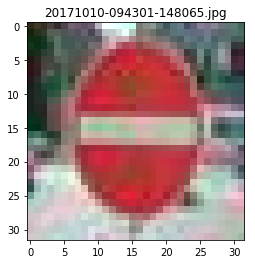

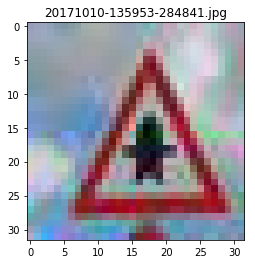

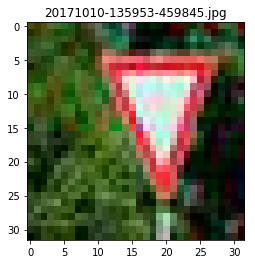

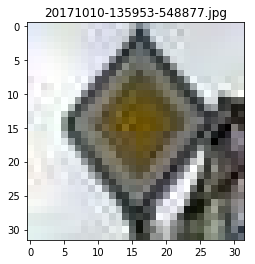

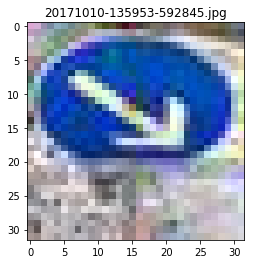

In [38]:
import os
import matplotlib.image as mpimg
from datetime import datetime
from PIL import Image 

dir="C:\\Users\\harsh\\CarND-Traffic-Sign-Classifier-Project\\extra\\"
files=[file for file in os.listdir(dir) if file.endswith('.jpg')]
extra_x = np.empty((0,32,32,3))
for image_path in files:
    image=mpimg.imread(dir + image_path)
    extra_x=np.append(extra_x,np.array([image]),axis=0)
    plt.title(image_path)
    plt.imshow(image)
    plt.show()

        


In [39]:
csv_data = np.genfromtxt('signnames.csv', delimiter=',', names=True, dtype=None)
sign_names = [t[1].decode('utf-8') for t in csv_data]

## Performance of the Test Images Downloaded run on the saved model

INFO:tensorflow:Restoring parameters from ./convolutional-net


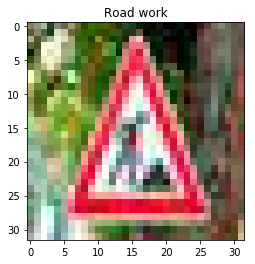

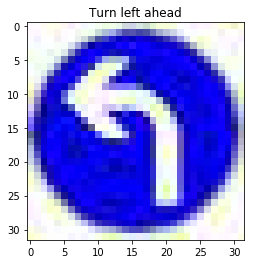

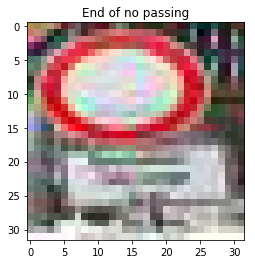

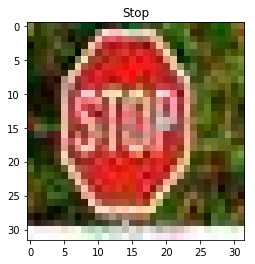

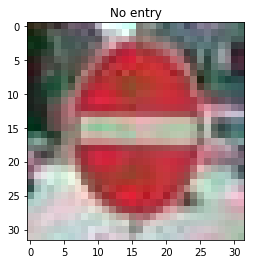

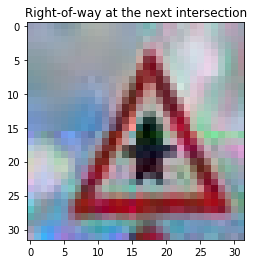

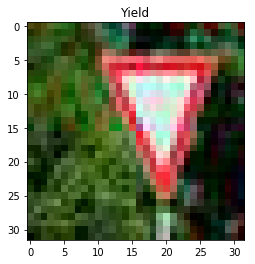

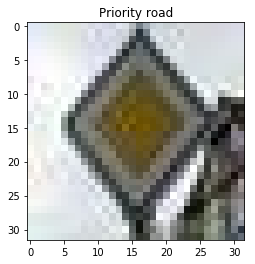

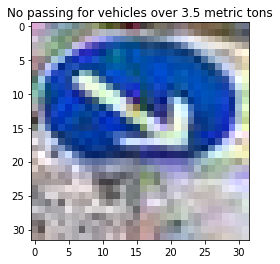

In [40]:
extra_x_norm = normalize(extra_x)
predicions = tf.argmax(fc,1)
predicted_classes = []

with tf.Session() as sess:
    #sess.run(tf.initialize_all_variables())
    new_saver = tf.train.import_meta_graph('convolutional-net.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    #sess.run(tf.initialize_all_variables())
    predicted_classes = sess.run(predicions, feed_dict={x: extra_x_norm, keep_prob: 1.0})

# print(predicted_classes)
for class_label,image_path in zip(predicted_classes, files):
    image = mpimg.imread(dir + image_path)
    plt.title(sign_names[class_label])
    plt.imshow(image)
    plt.show()

## Results

- 8 out of 9 images are classified correctly which results in 88.9% accuracy.
- It is compared to test data accuracy of 90%. The validation data accuracy is 98%.
- The last image is wrongly classified as No passing of vehicles over 3.5 metric tons.It might be because of the background of the image which is not clear and image is wrongly classified.

INFO:tensorflow:Restoring parameters from ./convolutional-net


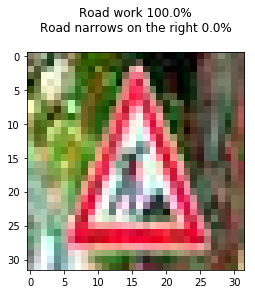

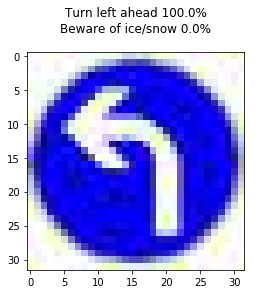

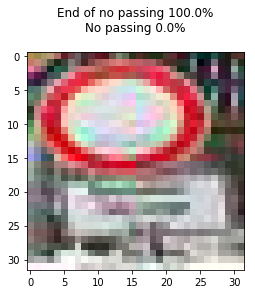

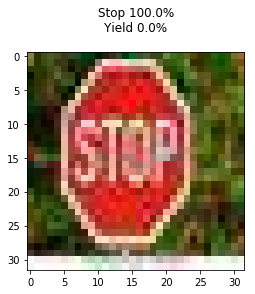

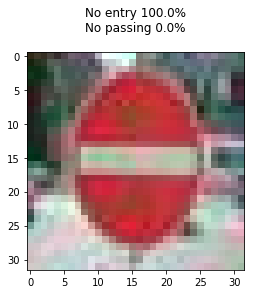

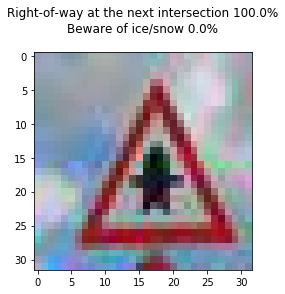

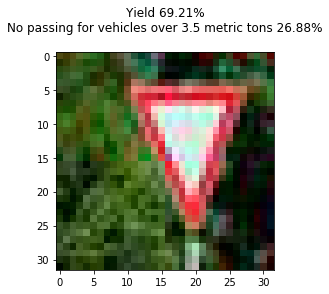

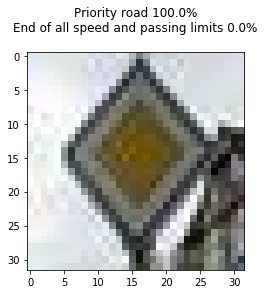

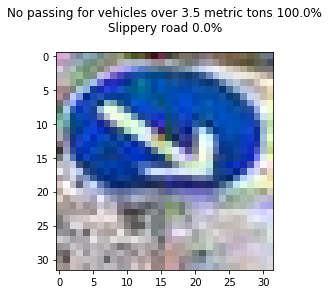

In [43]:
#Softmax Probabilities converted to percentages
probs_op = tf.nn.softmax(fc)            
top_k_operation = tf.nn.top_k(probs_op, k=2)
top_k = []
with tf.Session() as sess:
    #sess.run(tf.initialize_all_variables())
    new_saver = tf.train.import_meta_graph('convolutional-net.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    #sess.run(tf.initialize_all_variables())
    top_k = sess.run(top_k_operation, feed_dict={x: extra_x_norm, keep_prob: 1.0})
probable_values, class_labels = top_k[0], top_k[1]

for i in np.arange(len(class_labels)):
    image_path = files[i]
    image = mpimg.imread(dir + image_path)
    title=''
    for certainty, label in zip(probable_values[i], class_labels[i]):
        title += sign_names[label] + ' ' + str(round(certainty* 100., 2)) + '%\n'
    plt.title(title)
    plt.imshow(image)
    plt.show()

## Analysis of Softmax Probabilities

- The images correctly classified are very certain yielding 100% probable.
- The yield is correctly classified but it is only 69.21% probable.
- I have chosen k value in the top_k function to be 2 to get 2 probabilities answer.
- I guess if it is not finding out the classification, it tends to produce no passing for vehicles for 3.5 metric tons.
- Some of the images are very simple to classify and thus classifier provides good accuracy. 
- Future work is to work with very distinctive traffic signs.